# Logistic Regression Model to Predict Which Film Will Be Rented Again

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass 

from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split      
from sklearn.linear_model import LogisticRegression   

#%matplotlib inline

In [2]:
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


In [3]:
# Create a query to extract relevent information to build the prediction model.

query = '''SELECT f.film_id, title, c.name as category_name, f.rating, f.length, f.rental_duration, f.special_features, f.rental_rate, f.release_year, total_rentings
FROM (SELECT count(rental_date) as total_rentings, i.film_id
      FROM rental as r
      JOIN inventory as i
      USING (inventory_id)
      GROUP BY film_id
) t
RIGHT JOIN film as f
USING (film_id)
LEFT JOIN film_category as fa
USING (film_id)
LEFT JOIN category as c
USING (category_id);
'''

In [4]:
# Read the data into a Pandas dataframe.

data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,category_name,rating,length,rental_duration,special_features,rental_rate,release_year,total_rentings
0,1,ACADEMY DINOSAUR,Documentary,PG,86,6,"Deleted Scenes,Behind the Scenes",0.99,2006,24.0
1,2,ACE GOLDFINGER,Horror,G,48,3,"Trailers,Deleted Scenes",4.99,2006,7.0
2,3,ADAPTATION HOLES,Documentary,NC-17,50,7,"Trailers,Deleted Scenes",2.99,2006,12.0
3,4,AFFAIR PREJUDICE,Horror,G,117,5,"Commentaries,Behind the Scenes",2.99,2006,23.0
4,5,AFRICAN EGG,Family,G,130,6,Deleted Scenes,2.99,2006,12.0


## Exploring Data

In [5]:
data.shape

(1000, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1000 non-null   int64  
 1   title             1000 non-null   object 
 2   category_name     1000 non-null   object 
 3   rating            1000 non-null   object 
 4   length            1000 non-null   int64  
 5   rental_duration   1000 non-null   int64  
 6   special_features  1000 non-null   object 
 7   rental_rate       1000 non-null   float64
 8   release_year      1000 non-null   int64  
 9   total_rentings    958 non-null    float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB


In [7]:
data.film_id.nunique()

# 1000 films in total in our dataset

1000

In [8]:
data.rating.value_counts()

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [9]:
data.release_year.value_counts()

# Only 1 value(2006) will drop column later.

2006    1000
Name: release_year, dtype: int64

In [10]:
data.special_features.value_counts()

Trailers,Commentaries,Behind the Scenes                   79
Trailers                                                  72
Trailers,Commentaries                                     72
Trailers,Behind the Scenes                                72
Deleted Scenes,Behind the Scenes                          71
Commentaries,Behind the Scenes                            70
Behind the Scenes                                         70
Trailers,Deleted Scenes                                   66
Commentaries,Deleted Scenes,Behind the Scenes             66
Commentaries,Deleted Scenes                               65
Trailers,Commentaries,Deleted Scenes                      64
Commentaries                                              62
Deleted Scenes                                            61
Trailers,Commentaries,Deleted Scenes,Behind the Scenes    61
Trailers,Deleted Scenes,Behind the Scenes                 49
Name: special_features, dtype: int64

In [11]:
data.rental_duration.value_counts()

6    212
3    203
4    203
7    191
5    191
Name: rental_duration, dtype: int64

## Data Cleaning

In [12]:
#Changing movie title to lower case using str.title()

data['title'] = data['title'].str.title()

In [13]:
# Dropping release_year column since it only has 1 single value, therefore not useful to build our model.

data.drop(["release_year"], axis=1, inplace=True)


In [14]:
#Checking nulls

data.isna().sum()

film_id              0
title                0
category_name        0
rating               0
length               0
rental_duration      0
special_features     0
rental_rate          0
total_rentings      42
dtype: int64

In [15]:
# We have 43 nulls in rentings. It means 43 movies were not rented at all last year.
# Replace nulls with 0.

data['total_rentings'] = data['total_rentings'].fillna(0.0)

In [16]:
data.isna().sum()

film_id             0
title               0
category_name       0
rating              0
length              0
rental_duration     0
special_features    0
rental_rate         0
total_rentings      0
dtype: int64

### Numerical Variables

In [17]:
numerical = data.select_dtypes(include = np.number)
numerical.describe()

,film_id,length,rental_duration,rental_rate,total_rentings
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,115.272000,4.985000,2.980000,16.04500
std,288.819436,40.426332,1.411654,1.646393,7.34908
min,1.000000,46.000000,3.000000,0.990000,0.00000
25%,250.750000,80.000000,4.000000,0.990000,11.00000
50%,500.500000,114.000000,5.000000,2.990000,16.00000
75%,750.250000,149.250000,6.000000,4.990000,21.00000
max,1000.000000,185.000000,7.000000,4.990000,34.00000


 #### Checking for multicollinearity

In [18]:
#Creating a Correlation plot:

correlations_matrix = numerical.corr(method="spearman")
correlations_matrix

,film_id,length,rental_duration,rental_rate,total_rentings
film_id,1.000000,0.049021,-0.039453,-0.012866,-0.006185
length,0.049021,1.000000,0.061339,0.030608,-0.019783
rental_duration,-0.039453,0.061339,1.000000,0.025791,-0.076268
rental_rate,-0.012866,0.030608,0.025791,1.000000,-0.051765
total_rentings,-0.006185,-0.019783,-0.076268,-0.051765,1.000000


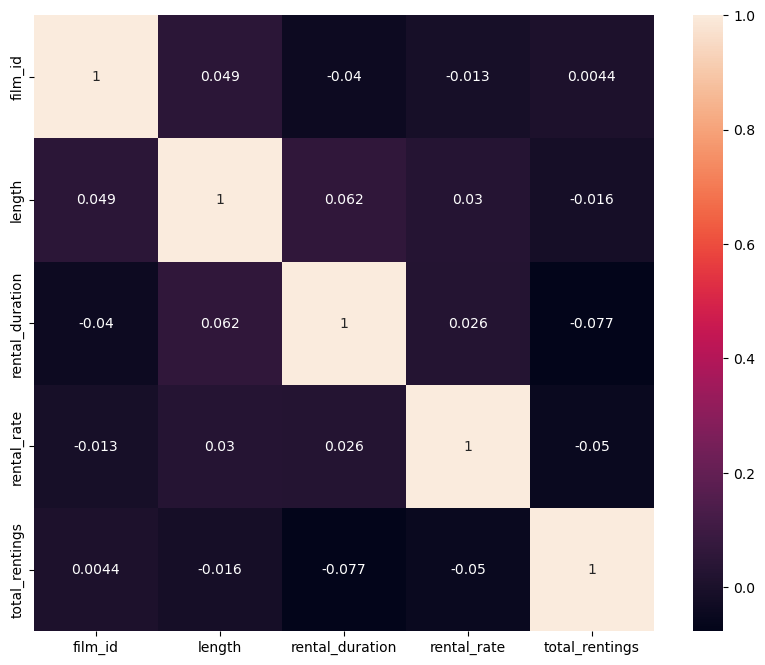

In [19]:
corr_matrix=numerical.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

##### None of the numerical features have a high correlation with one another. However for our model (logistic regression) we don't need Multicollinearity for the model to perform better.

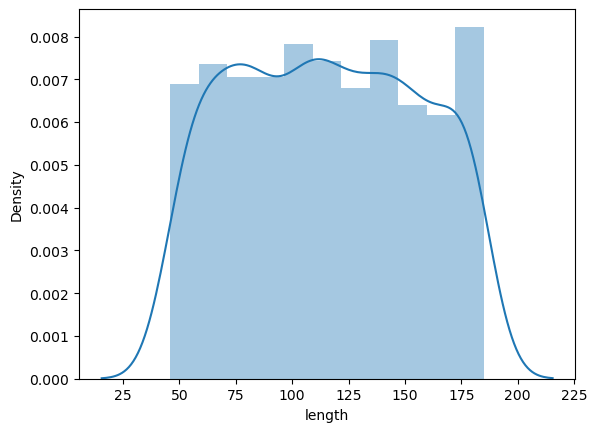

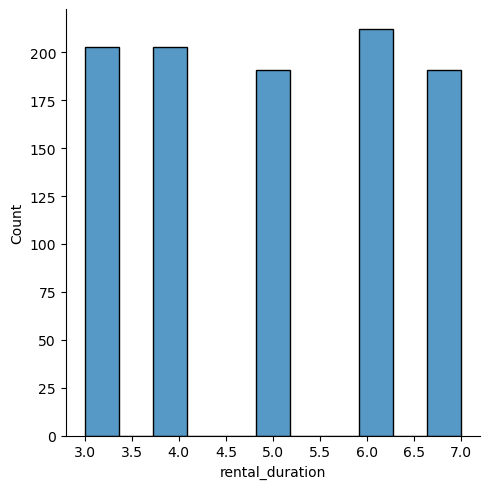

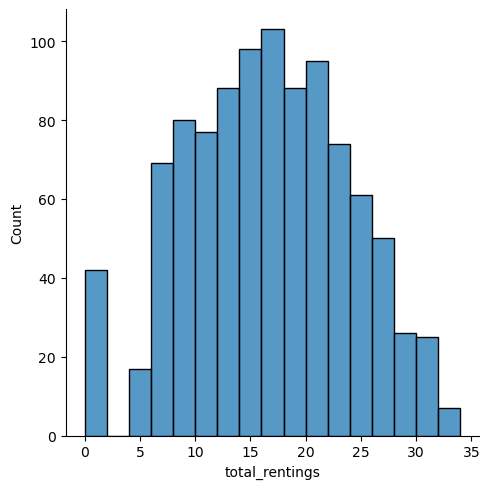

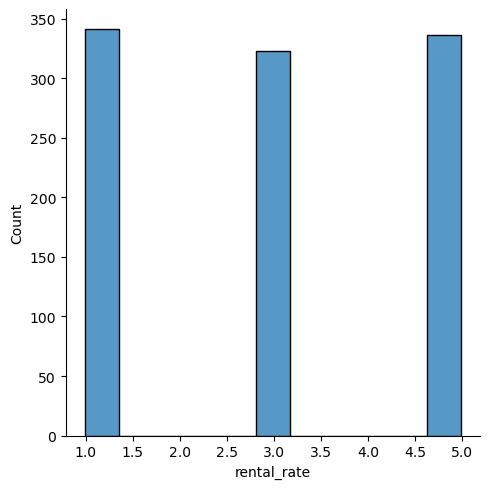

In [20]:
# Plotting Distribution of numerical features

sns.distplot(numerical["length"])
sns.displot(numerical["rental_duration"])
sns.displot(numerical["total_rentings"])
sns.displot(numerical["rental_rate"])

In [21]:
# Applying standard scaler to see if we can make "length" look more normal distributed

transformer = StandardScaler().fit(numerical)
num_normalized = transformer.transform(numerical)
num_trans = pd.DataFrame(num_normalized)
num_trans.columns = numerical.columns
num_trans.head()

,film_id,length,rental_duration,rental_rate,total_rentings
0,-1.730320,-0.724445,0.719374,-1.209308,1.082990
1,-1.726856,-1.664897,-1.406855,1.221461,-1.231382
2,-1.723391,-1.615399,1.428118,0.006077,-0.550684
3,-1.719927,0.042766,0.010631,0.006077,0.946850
4,-1.716463,0.364499,0.719374,0.006077,-0.550684


<AxesSubplot:xlabel='length', ylabel='Density'>

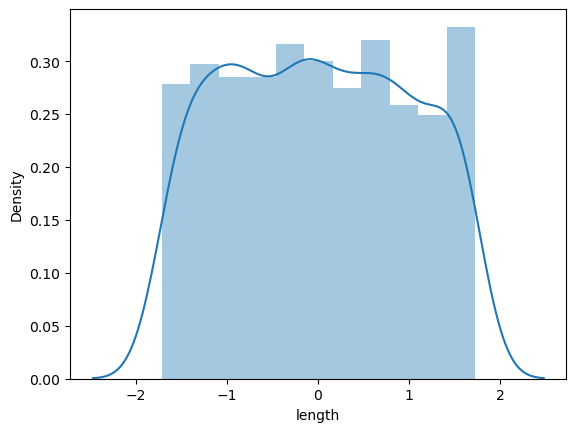

In [22]:
sns.distplot(num_trans["length"])


#### Transforming our numerical variables did not make any difference in distribution. However for our model (logistic regression) we don't need our variables to be normally distributed.

In [ ]:
#numerical2=numerical.copy()

In [ ]:
#Applying MinMaxScaler to see if it makes any difference to our model

#from sklearn.preprocessing import MinMaxScaler
#transformer = MinMaxScaler().fit(numerical2)
#num_normalized = transformer.transform(numerical2)
#num_normalized = pd.DataFrame(num_normalized)
#num_normalized.describe()

### Categorical Variables

In [23]:
#Get categorical data

cat = data.select_dtypes(include = np.object)
cat.head()

,title,category_name,rating,special_features
0,Academy Dinosaur,Documentary,PG,"Deleted Scenes,Behind the Scenes"
1,Ace Goldfinger,Horror,G,"Trailers,Deleted Scenes"
2,Adaptation Holes,Documentary,NC-17,"Trailers,Deleted Scenes"
3,Affair Prejudice,Horror,G,"Commentaries,Behind the Scenes"
4,African Egg,Family,G,Deleted Scenes


#### Categorical Variables Visualization

In [24]:
# TARGET VARIABLE: creating a function to assign 0 as not rented at all last year (between 2006-02-14  - 2005-05-24) and 1 as rented last year.
# Has the movie been rented last year? (binary: “1”, means “Yes”, “0” means “No”)

rentals = []

for row in data['total_rentings']:
    if row == 0:
        rentals.append(0)
    else:
        rentals.append(1)   

In [27]:
# Adding our Target "rentals" list as a column in our dataset.

data['rentals'] = rentals

In [30]:
data.rentals.value_counts()
# 958 films rented last year
# 42 films not rented last year

1    958
0     42
Name: rentals, dtype: int64

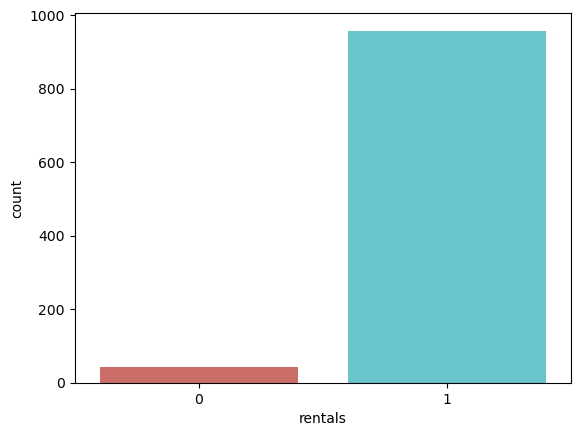

In [31]:
sns.countplot(x=data['rentals'], data=data, palette='hls')
plt.show()

We can see our data is severely imbalanced, therefore it could cause our prediction model to be biased towards the most common class, in this case "1" - film rented last year.

<Figure size 1000x600 with 0 Axes>

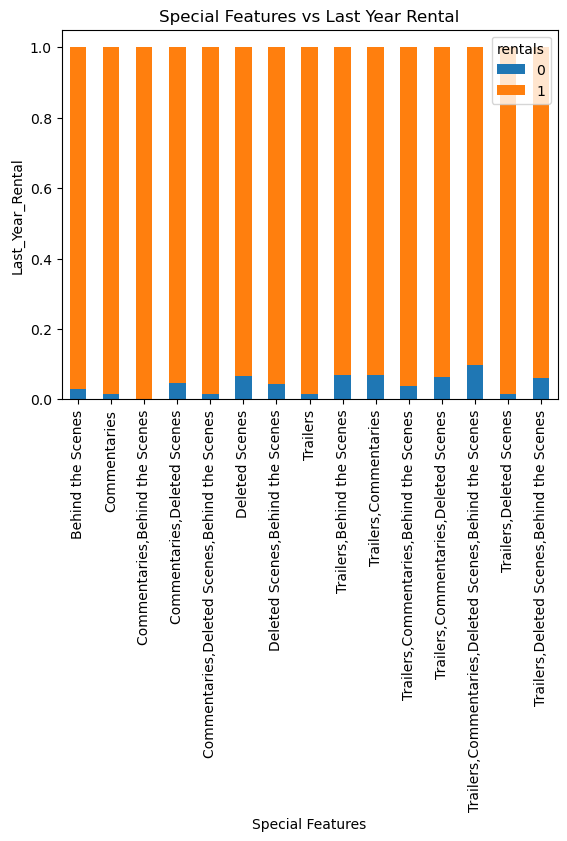

<Figure size 1000x600 with 0 Axes>

In [32]:
#lets visualize our categorical independent variables against our Target "rentals"

table=pd.crosstab(data.special_features,data.rentals)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Special Features vs Last Year Rental')
plt.xlabel('Special Features')
plt.ylabel('Last_Year_Rental')
plt.figure(figsize=(10,6))

#Special Features might be a good predictor of our target variable.

Text(0, 0.5, 'Last Year Rental')

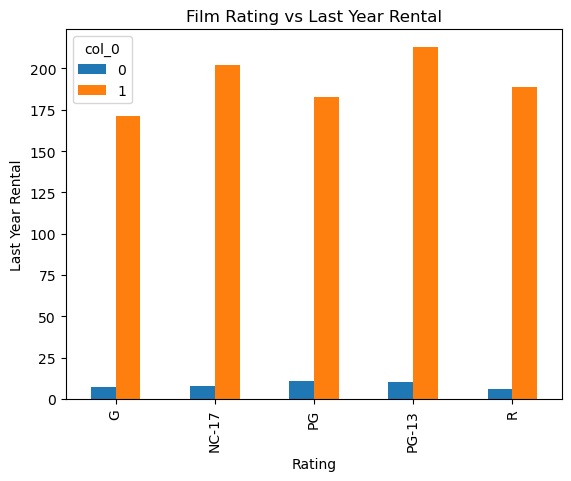

In [33]:
pd.crosstab(data.rating,rentals).plot(kind='bar')
plt.title('Film Rating vs Last Year Rental')
plt.xlabel('Rating')
plt.ylabel('Last Year Rental')

#Film Rating may not be a good predictor of our target variable.

Text(0, 0.5, 'Last Year Rental')

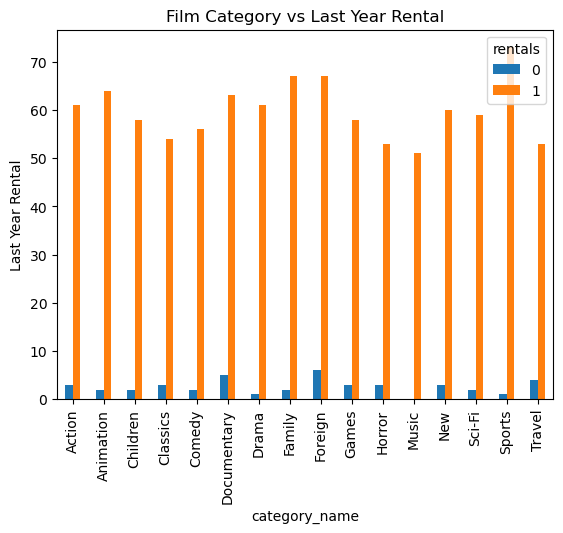

In [34]:
pd.crosstab(data.category_name,data.rentals).plot(kind='bar')
plt.title('Film Category vs Last Year Rental')
plt.xlabel('category_name')
plt.ylabel('Last Year Rental')


# Film Category might be a good predictor of our target variable.

#### Encoding Categoricals (Using Get Dumies)


In [36]:
cat = cat.drop(['title'], axis=1) 

In [61]:
categorical = pd.get_dummies(cat, columns=['category_name', 'rating', 'special_features'])
categorical.head()

,category_name_Action,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
#Using onehotencoder

#encoder = OneHotEncoder(handle_unknown='error', drop='first')
#encoder.fit(cat)

In [ ]:
#encoded = encoder.transform(cat).toarray() 
#categorical = pd.DataFrame(encoded)

In [ ]:
# Add column names to the dataframe
#categorical.columns = encoder.get_feature_names_out()
#categorical.head()

### Train-Test Split and Training Model

In [38]:
# Dropping'total_rentings' columns so it won't be included when I do Train Test Split.

numerical = numerical.drop(['total_rentings'], axis=1) 

In [41]:
y = data['rentals'] # Our TARGET. We want to predict if Movie will be rented again.
#X = pd.concat((numerical, categorical), axis=1) #concats numerical variables and encoded categorical variables

X = pd.concat((numerical, categorical), axis=1)

In [43]:
X.shape

(1000, 40)

In [44]:
# Separating training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100) #30% for test set 70% for train test.

In [45]:
X_test.shape

(300, 40)

In [50]:
y_train.shape

(700,)

In [51]:
# Training our data using Logistic Regression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)   

In [53]:
# How well did our model perform? Let's check the predictions (We predict on the testing dataset)

predictions = classification.predict(X_test)
pd.Series(predictions).value_counts() 

1    300
dtype: int64

In [54]:
#Let's check the real/True values

y_test.value_counts() 

1    287
0     13
Name: rentals, dtype: int64

I predicted 300 values to be True, however 13 of them were False.

#### Confusion Matrix to Evaluate Performance of Model

In [57]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

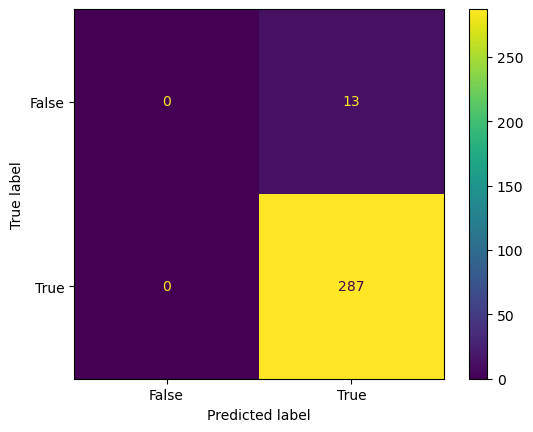

In [58]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

I predicted 300 values to be True, however 13 of them were False

In [71]:
# Accuracy
classification.score(X_test, y_test)

0.9566666666666667

### Accuracy is 96%.

In [77]:
#Create dataframe for visualising the differences between True and Predicted values

results = pd.DataFrame()
results['true'] = y_test
results['pred'] = predictions
results['diff'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results

,true,pred,diff
249,1,1,0
353,1,1,0
537,1,1,0
424,1,1,0
564,1,1,0
...,...,...,...
193,1,1,0
838,1,1,0
974,1,1,0
203,1,1,0
